In [1]:
import sys
import importlib
import numpy as np
import mxnet as mx
import myutils

In [2]:
class Dataset(mx.gluon.data.Dataset):
    def __init__(self, filename):
        super(Dataset, self).__init__()
        import os
        
        windows_dataset_root = r'D:\Documents\Data_Files\Pascal'
        windows_dataset_root2 = r'h:\hlc\Datasets\Pascal'
        linux_dataset_root = '../Dataset/Pascal'
        dataset_root = windows_dataset_root
        img_idx_directory = os.path.sep.join([dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'ImageSets', 'Main'])
        self.img_directory = os.path.sep.join([dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'JPEGImages'])
        self.annotation_directory = os.path.sep.join([dataset_root, 'VOC2007', 'VOCtrainval_06-Nov-2007', 'VOCdevkit', 
                                                  'VOC2007', 'Annotations'])
        self.class_name = filename.split('_')[0]
        
        self.img_indices = []
        with open (os.path.sep.join([img_idx_directory, filename]), 'r') as f:
            import re
            import os
            regex = re.compile ('[ ]+')
            while(True):
                line = f.readline()
                if line == '':
                    break
                img_idx, in_the_class = regex.split(line.rstrip('\n'))
                in_the_class = int(in_the_class)
                if (in_the_class == 1):
                    self.img_indices.append(img_idx)
        self.len = len(self.img_indices)
        return


    def __getitem__(self, idx):
        import os
        import mxnet as mx
        import xml.etree.ElementTree as et
        
        img_path = os.path.sep.join([self.img_directory, str(self.img_indices[idx])+'.jpg'])
        img = mx.image.imread(img_path)
        
        label_path = os.path.sep.join([self.annotation_directory, str(self.img_indices[idx])+'.xml'])
        tree = et.parse(label_path)
        root = tree.getroot()
        obj_iter = root.iterfind('object')
        for obj in obj_iter:
            if (obj.find('name').text == self.class_name):
                bndbox = obj.find('bndbox')
                coors = mx.nd.array([int(coor.text) for coor in bndbox])
                label = mx.nd.concat(mx.nd.array([1]), coors, dim=0)
                label = label.reshape(shape=(1, 5))
        return img.asnumpy(), label.astype('int').asnumpy()
    
    
    def __len__(self):
        return self.len
    

dataset = Dataset('cat_train.txt')
dataloader = mx.gluon.data.DataLoader(dataset, batch_size=10, shuffle=True)
print('total num of data entries:', len(dataset))

total num of data entries: 163


[[  1   2   1 306 333]]


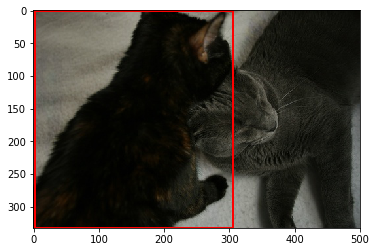

In [3]:
img, label = dataset[1]
print(label)
myutils.data_visualize(img=img, bboxes=label[:, 1:])

In [4]:
ctx = mx.gpu()
class SSDNet (mx.gluon.HybridBlock):
    def __init__ (self, **kwargs):
        super(SSDNet, self).__init__(**kwargs)
        self.ctx = ctx
        
        import mxnet as mx
        self.anchor_ratios = [1, 2, 0.5]
        self.anchor_sizes = [0.5, 0.25, 0.1]
        
        linux_model_params_root = '../Parameters'
        windows_model_params_root2 = 'h:\hlc\Parameters'
        vgg16 = mx.gluon.model_zoo.vision.vgg16 (pretrained=True, ctx=ctx)
        feature_map = vgg16.features[0:30]

        feature_map.add (mx.gluon.nn.Conv2D (1024, kernel_size=(3, 3), padding=(1, 1)))
        feature_map.add (mx.gluon.nn.Activation('relu'))
        feature_map.add (mx.gluon.nn.Conv2D (1024, kernel_size=(1, 1)))
        feature_map.add (mx.gluon.nn.Activation('relu'))

        feature_map.add (mx.gluon.nn.Conv2D (512, kernel_size=(3, 3), strides=2, padding=(1, 1)))
        feature_map.add (mx.gluon.nn.Activation('relu'))

        feature_map.add (mx.gluon.nn.Conv2D (256, kernel_size=(3, 3), strides=2, padding=(1, 1)))
        feature_map.add (mx.gluon.nn.Activation('relu'))

        feature_map.add (mx.gluon.nn.Conv2D (256, kernel_size=(3, 3)))
        feature_map.add (mx.gluon.nn.Activation('relu'))

        feature_map.add (mx.gluon.nn.Conv2D (256, kernel_size=(3, 3)))
        feature_map.add (mx.gluon.nn.Activation('relu'))

        self.conv4_3 = feature_map[:23]
        self.conv7 = feature_map[:34]
        self.conv8_2 = feature_map[:36]
        self.conv9_2 = feature_map[:38]
        self.conv10_2 = feature_map[:40]
        self.conv11_2 = feature_map[:42]
        
        with self.name_scope():
            self.feat4_3 = self.conv4_3
            self.feat7 = self.conv7
            self.feat8_2 = self.conv8_2
            self.feat9_2 = self.conv9_2
            self.feat10_2 = self.conv10_2
            self.feat11_2 = self.conv11_2
            
            self.cls_predictor4_3 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)  # 每个位置5个anchors，背景+物体共两个类别
            self.cls_predictor7 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            self.cls_predictor8_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            self.cls_predictor9_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            self.cls_predictor10_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            self.cls_predictor11_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
            
            self.bbox_predictor4_3 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor7 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor8_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor9_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor10_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            self.bbox_predictor11_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
            
            
    def forward (self, x):
        feat4_3 = self.conv4_3(x)
        feat7 = self.conv7(x)
        feat8_2 = self.conv8_2(x)
        feat9_2 = self.conv9_2(x)
        feat10_2 = self.conv10_2(x)
        feat11_2 = self.conv11_2(x)
        
        anchors4_3 = mx.nd.contrib.MultiBoxPrior (feat4_3, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors7 = mx.nd.contrib.MultiBoxPrior (feat7, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors8_2 = mx.nd.contrib.MultiBoxPrior (feat8_2, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors9_2 = mx.nd.contrib.MultiBoxPrior (feat9_2, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors10_2 = mx.nd.contrib.MultiBoxPrior (feat10_2, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors11_2 = mx.nd.contrib.MultiBoxPrior (feat11_2, sizes=self.anchor_sizes, ratios=self.anchor_ratios)
        anchors = mx.nd.concat (anchors4_3, anchors7, anchors8_2, anchors9_2, anchors10_2, anchors11_2, dim=1)
        
        cls_predictor4_3 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds4_3 = self.cls_predictor4_3 (feat4_3)
        cls_preds4_3 = cls_preds4_3.transpose(axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor7 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds7 = self.cls_predictor7 (feat7)
        cls_preds7 = cls_preds7.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor8_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds8_2 = self.cls_predictor8_2 (feat8_2)
        cls_preds8_2 = cls_preds8_2.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor9_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds9_2 = self.cls_predictor9_2 (feat9_2)
        cls_preds9_2 = cls_preds9_2.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor10_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds10_2 = self.cls_predictor10_2 (feat10_2)
        cls_preds10_2 = cls_preds10_2.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_predictor11_2 = mx.gluon.nn.Conv2D (5 * 2, kernel_size=3, padding=1)
        cls_preds11_2 = self.cls_predictor11_2 (feat11_2)
        cls_preds11_2 = cls_preds11_2.transpose (axes=(0, 2, 3, 1)).flatten()
        
        cls_preds = mx.nd.concat (cls_preds4_3, cls_preds7, cls_preds8_2, cls_preds9_2, cls_preds10_2,
                                  cls_preds11_2, dim=1)
        cls_preds = cls_preds.reshape (shape=(0, -1, 2))
        
        
        bbox_predictor4_3 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds4_3 = self.bbox_predictor4_3 (feat4_3)
        bbox_preds4_3 = bbox_preds4_3.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor7 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds7 = self.bbox_predictor7 (feat7)
        bbox_preds7 = bbox_preds7.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor8_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds8_2 = self.bbox_predictor8_2 (feat8_2)
        bbox_preds8_2 = bbox_preds8_2.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor9_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds9_2 = self.bbox_predictor9_2 (feat9_2)
        bbox_preds9_2= bbox_preds9_2.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor10_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds10_2 = self.bbox_predictor10_2 (feat10_2)
        bbox_preds10_2 = bbox_preds10_2.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_predictor11_2 = mx.gluon.nn.Conv2D (5 * 4, kernel_size=3, padding=1)
        bbox_preds11_2 = self.bbox_predictor11_2 (feat11_2)
        bbox_preds11_2 = bbox_preds11_2.transpose(axes=(0, 2, 3, 1)).flatten()
        
        bbox_preds = mx.nd.concat (bbox_preds4_3, bbox_preds7, bbox_preds8_2, bbox_preds9_2,
                                   bbox_preds10_2, bbox_preds11_2, dim=1)
        
        return anchors, cls_preds, bbox_preds
    
net = SSDNet()
net.hybridize()
net.initialize(init=mx.init.Xavier(), ctx=ctx)
anchors, cls_preds, bbox_preds = net(mx.nd.uniform(0, 1, shape=(1, 3, 300, 300), ctx=ctx))
print ('anchors:', anchors.shape)
print ('cls_preds:', cls_preds.shape)
print ('bbox_preds:', bbox_preds.shape)

C:\IntelPython3\lib\site-packages\mxnet\gluon\parameter.py:811: UserWarning: Parameter 'vgg0_conv0_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
C:\IntelPython3\lib\site-packages\mxnet\gluon\parameter.py:811: UserWarning: Parameter 'vgg0_conv0_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
C:\IntelPython3\lib\site-packages\mxnet\gluon\parameter.py:811: UserWarning: Parameter 'vgg0_conv1_weight' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
C:\IntelPython3\lib\site-packages\mxnet\gluon\parameter.py:811: UserWarning: Parameter 'vgg0_conv1_bias' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
C:\IntelPython3\lib\site-packages\mxnet\gluo

anchors: (1, 9045, 4)
cls_preds: (1, 9045, 2)
bbox_preds: (1, 36180)


In [5]:
cls_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
bbox_loss = mx.gluon.loss.L1Loss()
trainer = mx.gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'momentum':0.05})

In [12]:
trainer.set_learning_rate(0.01)

In [15]:
batch_size = 5
img, label = dataset[2]
mx_img, mx_label = myutils.prepare_datum_for_training(img, label)

for batch in range(50):
    with mx.autograd.record():
        anchors, cls_preds, bbox_preds = net(mx_img.as_in_context(ctx))
        
        box_target, box_mask, cls_target = mx.nd.contrib.MultiBoxTarget(anchor=anchors.as_in_context(mx.cpu()),
                                                                        cls_pred=cls_preds.transpose((0, 2, 1)).as_in_context(mx.cpu()),
                                                                        label=mx_label.as_in_context(mx.cpu()),
                                                                        overlap_threshold=0.25)
        box_target = box_target.as_in_context(ctx)
        box_mask = box_mask.as_in_context(ctx)
        cls_target = cls_target.as_in_context(ctx)

        batch_cls_loss = cls_loss (cls_preds.as_in_context(ctx), cls_target)
        batch_bbox_loss = bbox_loss (bbox_preds * box_mask, box_target * box_mask)
        batch_loss = batch_cls_loss + batch_bbox_loss

    batch_loss.backward()
    trainer.step(1)

    print ('batch', str(batch)+':', batch_loss.mean().asscalar())

batch 0: 0.03655607
batch 1: 0.03661421
batch 2: 0.03626733
batch 3: 0.03615855
batch 4: 0.035832886
batch 5: 0.0358015
batch 6: 0.035590265
batch 7: 0.03558648
batch 8: 0.035357088
batch 9: 0.03551174
batch 10: 0.035404194
batch 11: 0.035443
batch 12: 0.03525849
batch 13: 0.035197377
batch 14: 0.034956675
batch 15: 0.034816414
batch 16: 0.03443429
batch 17: 0.034328025
batch 18: 0.03409522
batch 19: 0.033985153
batch 20: 0.033857916
batch 21: 0.034014884
batch 22: 0.034074042
batch 23: 0.034347378
batch 24: 0.03440649
batch 25: 0.034389604
batch 26: 0.03433464
batch 27: 0.034114234
batch 28: 0.033950415
batch 29: 0.033792034
batch 30: 0.033642188
batch 31: 0.033516638
batch 32: 0.033500668
batch 33: 0.033502214
batch 34: 0.033580594
batch 35: 0.033422496
batch 36: 0.03333825
batch 37: 0.03321483
batch 38: 0.033078033
batch 39: 0.03284821
batch 40: 0.032674123
batch 41: 0.03255061
batch 42: 0.032379948
batch 43: 0.032278184
batch 44: 0.032129627
batch 45: 0.032325227
batch 46: 0.032204


[[0.         0.9999616  0.08325577 0.04194713 0.9024398  0.98456573]
 [0.         0.89776945 0.07514626 0.         0.9049985  0.532122  ]
 [0.         0.8040217  0.18756518 0.46975198 0.79317856 1.        ]
 [0.         0.67804223 0.3194347  0.15133265 0.71179146 0.93018246]
 [0.         0.6216819  0.14238748 0.3188401  0.8438219  0.6758203 ]
 [0.         0.5854525  0.3986788  0.37921348 0.62474513 0.6024263 ]
 [0.         0.34803587 0.45545733 0.447182   0.55174136 0.54512084]
 [0.         0.1998509  0.3557229  0.57037383 1.         1.        ]
 [0.         0.15045838 0.35780266 0.         1.         0.39024198]
 [0.         0.1338924  0.         0.6145672  0.40677285 1.        ]
 [0.         0.11931138 0.         0.         0.34526065 0.36115694]
 [0.         0.11663054 0.6184473  0.59416986 1.         0.93373585]
 [0.         0.11499153 0.64861995 0.00873458 0.99179655 0.3423036 ]
 [0.         0.08637996 0.         0.21929872 0.4334901  0.76850045]
 [0.         0.07015017 0.365147 

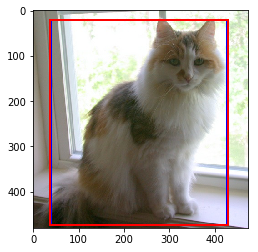

In [17]:
myutils.validate_data_n(2, dataset=dataset, net=net, the_first_n_bboxes=1)

In [20]:
params = net.bbox_predictor11_2.params
params

ssdnet0_conv11_ (
  Parameter ssdnet0_conv11_weight (shape=(20, 256, 3, 3), dtype=<class 'numpy.float32'>)
  Parameter ssdnet0_conv11_bias (shape=(20,), dtype=<class 'numpy.float32'>)
)

In [25]:
param = params['ssdnet0_conv11_weight']

In [40]:
grad = param.grad()
grad = grad.asnumpy()
len(grad[grad == 0]) == grad.size

True

In [32]:
np_grad = 

(20, 256, 3, 3)

In [2]:
import gluoncv as gcv
net2 = gcv.model_zoo.ssd_512_resnet50_v1_voc(pretrained=True)

C:\IntelPython3\lib\site-packages\mxnet\gluon\block.py:421: UserWarning: load_params is deprecated. Please use load_parameters.
  warnings.warn("load_params is deprecated. Please use load_parameters.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


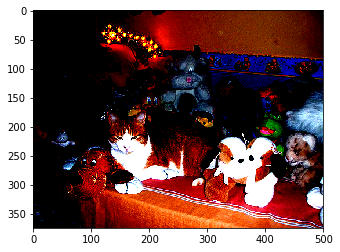

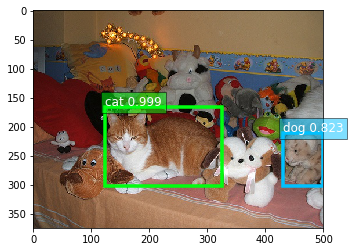

In [79]:
img_val, label_val = myutils.get_data_n(data_iter=data_iter, n=30)
mx_img_val = img_val.astype('float32')/255
mx_img_val = mx.nd.array(mx_img_val)
mx_img_val = mx.img.color_normalize(mx_img_val, mx.nd.array(myutils.mean), mx.nd.array(myutils.std))
mx_img_val = myutils.to_tensor(mx_img_val)
mx_img_val = mx_img_val.expand_dims(axis=0)
plt.imshow(mx_img_val[0].transpose(axes=(1, 2, 0)).asnumpy())
plt.show()

output = net2(mx_img_val)
out_1, out_2, out_3 = output
ax = gcv.utils.viz.plot_bbox(img_val, out_3[0], out_2[0],
                         out_1[0], class_names=net2.classes, thresh=0.5)
plt.show()